In [1]:
%matplotlib inline

Previous block must be executed in advance so as to ensure that the visualization of the different figures work well.


# Transfer Learning for Computer Vision Tutorial
**Author**: Fernando Fernández-Martínez (based on a previous work by [Sasank Chilamkurthy](https://chsasank.github.io))

In this tutorial, we will learn how to train a convolutional neural network (ConvNet or CNN) for image classification using transfer learning (TL). You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/).

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on [Imagenet](https://www.image-net.org/update-mar-11-2021.php) 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


# Step 0) Computer vision libraries in PyTorch

In [2]:
# License: BSD
# Author: Fernando Fernandez-Martinez (based on previous work by Sasank Chilamkurthy)

from __future__ import print_function, division

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np

# torchvision	library: it contains datasets, model architectures and image transformations often used for computer vision problems.
import torchvision

# torchvision.datasets: here you'll find many example computer vision datasets for a range of problems from image classification,
# object detection, image captioning, video classification and more. It also contains a series of base classes for making custom datasets.

# torchvision.models:	this module contains well-performing and commonly used computer vision model architectures implemented in PyTorch,
# you can use these with your own problems.

# torchvision.transforms:	often images need to be transformed (turned into numbers/processed/augmented) before being used with a model,
# common image transformations are found here.
from torchvision import datasets, models, transforms

# Import matplotlib for visualization
import matplotlib.pyplot as plt
import time
import os
import copy

# upload external file before import
from google.colab import files

cudnn.benchmark = True
plt.ion()   # interactive mode

# Step 1) Connect to your Google Drive and unzip required data
This notebook will initially request access to your Google Drive files. You should give it access to Google Drive in order to mount it and access its content. By giving such access, the code running in the notebook will be able to modify the files in your Google Drive (this is mandatory to be able to download the models that will result from the training process).

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


First run of this notebook will require you to unzip the dataset that we are going to use as a baseline to become familiar with the training process.

## General path configuration

In [24]:
general_path = "/content/gdrive/MyDrive/image_recognition/"

This cell has the command to create the required folder:

In [30]:
import os

print(f"Creando carpeta en: {general_path}")

os.makedirs(general_path, exist_ok=True)

# Verificación inmediata
if os.path.exists(general_path):
    print("✅ Carpeta general creada correctamente")
else:
    print("❌ Hubo un error creando la carpeta")

# Tambien nos aseguramos de crear la carpeta data
os.makedirs(general_path + "data/", exist_ok=True)

# Verificación inmediata
if os.path.exists(general_path + "data/"):
    print("✅ Carpeta data creada correctamente")
else:
    print("❌ Hubo un error creando la carpeta")

Creando carpeta en: /content/gdrive/MyDrive/image_recognition/
✅ Carpeta general creada correctamente
✅ Carpeta data creada correctamente


Next cell directly downloads the dataset required for the first run of the notebook from https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [26]:
!wget -P "{general_path}" https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2025-12-07 18:06:18--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.215.59, 99.84.215.89, 99.84.215.76, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.215.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘/content/gdrive/MyDrive/image_recognition/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  53.3MB/s    in 0.8s    

2025-12-07 18:06:19 (53.3 MB/s) - ‘/content/gdrive/MyDrive/image_recognition/hymenoptera_data.zip’ saved [47286322/47286322]



Finally, the notebook automatically extracts the content of the zip file to the "data/" directory.


In [34]:
!unzip -o -q "{general_path}/hymenoptera_data.zip" -d "{general_path}data/"

# Step 2) Getting data ready

We will use torchvision and torch.utils.data packages for loading the
data.

First, we will start by solving the problem of training a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.




In [35]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),  # Escalado sin perder información
        transforms.RandomHorizontalFlip(p=0.5),  # Mantiene la probabilidad explícita
        transforms.RandomRotation(15),  # Pequeña rotación para variabilidad
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),  # Variaciones de color
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),  # Evita distorsión
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2.1)  Getting the dataset
DO NOT FORGET TO CHANGE `notebook_run` ACCORDINGLY!!!

**IMPORTANT FOR 2ND RUN: DO NOT FORGET TO UPDATE THE DATASET FOLDER TO MATCH YOURS!!!**

In [36]:
notebook_run = 0
if notebook_run == 0:
  data_dir = general_path + 'data/hymenoptera_data' # Baseline example to familiarize with all the stuff
else:
  data_dir = general_path + 'data/new_dataset' # After completing a first run WE MUST UPDATE THIS to use our own data

In [37]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

### 2.2) Prepare DataLoader

Now we've got a dataset ready to go.
The next step is to prepare it with a torch.utils.data.DataLoader or DataLoader for short. The DataLoader does what you think it might do: **it helps load data into a model**, for training and for inference.

It turns a large Dataset into a Python iterable of smaller chunks.
These smaller chunks are called **batches** or **mini-batches** and can be set by the **batch_size** parameter.

Why do this? Because it's more computationally efficient.
In an ideal world you could do the forward pass and backward pass across all of your data at once.
But once you start using really large datasets, unless you've got infinite computing power, it's easier to break them up into batches.
It also gives your model more opportunities to improve.
With mini-batches (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

What's a good batch size?

32 is a good place to start for a fair amount of problems.
But since this is a value you can set (a hyperparameter) you can try all different kinds of values, though generally powers of 2 are used most often (e.g. 32, 64, 128, 256, 512).

In [38]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 2.3) Define the problem classes
**IMPORTANT FOR 2ND RUN: DO NOT FORGET TO CHANGE `class_names` ACCORDINGLY!!!**

In [55]:
if notebook_run == 0:
  class_names = image_datasets['train'].classes
else:
  class_names = sorted(['bottle', 'mouse', 'pencilcase', 'raspberry']) # Update this accordingly

print(class_names)
root_class_names = '_'.join(class_names)

['ants', 'bees']


### 2.4) Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


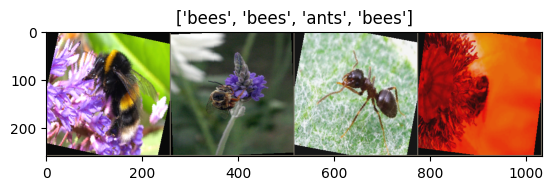

In [41]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Step 3) Functionizing training and test loops

## 3.1) Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [47]:
import time
import copy
import torch

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())

                if scheduler is not None and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step()  # Adjust LR if not using ReduceLROnPlateau
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

                # Check Early Stopping condition
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0  # Reset counter
                else:
                    early_stop_counter += 1

                if scheduler is not None and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)  # Adjust LR based on val_loss

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

        # Stop training if no improvement for `patience` epochs
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

## 3.2) Visualizing the model predictions

Generic function to display predictions for a few images




In [48]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                print(f'predicted: {class_names[preds[j]]} ({preds[j]})')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Step 4) Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [49]:
if notebook_run == 0:
  model_ft = models.resnet18(pretrained=True)
else:
  model_ft = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

print(model_ft)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Asegurar que class_names está definido
assert 'class_names' in locals(), "ERROR: 'class_names' no está definido antes de modificar la última capa."

if notebook_run == 0:
    # ResNet: Modificamos la última capa de clasificación
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, len(class_names))
else:
    # MobileNet: Modificamos la última capa de clasificación en el bloque classifier
    num_ftrs = model_ft.classifier[1].in_features
    model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# Enviar modelo a GPU/CPU
model_ft = model_ft.to(device)

# Configurar función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Scheduler dinámico recomendado (en vez de StepLR)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.1, patience=3)

### 4.1) Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [52]:
model_ft, train_losses, val_losses, train_accs, val_accs = train_model(
    model_ft, criterion, optimizer_ft, scheduler, dataloaders, dataset_sizes, device, num_epochs=50, patience=7
)

Epoch 0/49
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5979 Acc: 0.6885
val Loss: 0.4094 Acc: 0.8235

Epoch 1/49
----------
train Loss: 0.6317 Acc: 0.7664
val Loss: 0.4145 Acc: 0.8235

Epoch 2/49
----------
train Loss: 0.3679 Acc: 0.8566
val Loss: 0.3907 Acc: 0.8366

Epoch 3/49
----------
train Loss: 0.3595 Acc: 0.8648
val Loss: 0.2239 Acc: 0.9281

Epoch 4/49
----------
train Loss: 0.3767 Acc: 0.8648
val Loss: 0.3473 Acc: 0.8889

Epoch 5/49
----------
train Loss: 0.3703 Acc: 0.8770
val Loss: 0.2100 Acc: 0.9281

Epoch 6/49
----------
train Loss: 0.3882 Acc: 0.8689
val Loss: 0.2390 Acc: 0.9085

Epoch 7/49
----------
train Loss: 0.5730 Acc: 0.8197
val Loss: 0.2891 Acc: 0.8954

Epoch 8/49
----------
train Loss: 0.3178 Acc: 0.9057
val Loss: 0.8024 Acc: 0.8039

Epoch 9/49
----------
train Loss: 0.3720 Acc: 0.8689
val Loss: 0.3771 Acc: 0.8824

Epoch 10/49
----------
train Loss: 0.3734 Acc: 0.8648
val Loss: 0.3639 Acc: 0.8889

Epoch 11/49
----------
train Loss: 0.1221 Acc: 0.9631
val Loss: 0.3736 Acc: 0.9085

Epoch 12/49
----------
t

## 4.2) Make and evaluate random predictions with best model

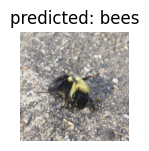

predicted: bees (1)


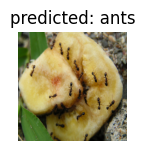

predicted: ants (0)


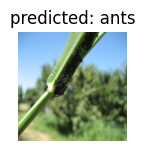

predicted: ants (0)


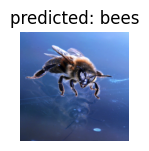

predicted: bees (1)


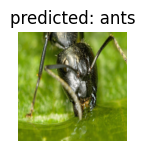

predicted: ants (0)


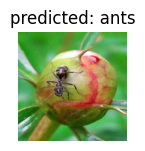

predicted: ants (0)


In [53]:
visualize_model(model_ft)

## 4.3) Visualizing training and validation losses

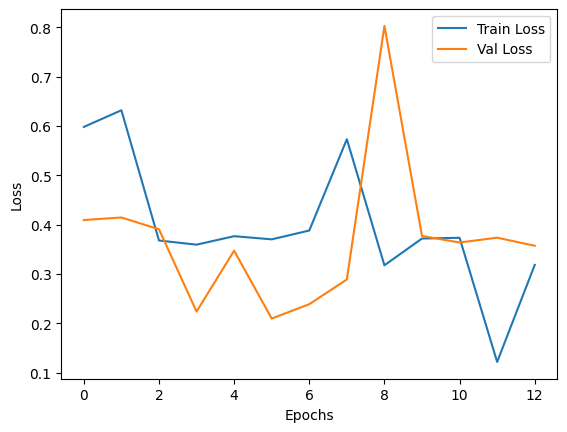

In [54]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 4.4) Saving the model

In [57]:
if notebook_run == 0:
  model_filename = root_class_names + '-FULL_FT.pth'
else:
  model_filename = root_class_names + '-FULL_FT_custom.pth'

torch.save(model_ft.state_dict(), model_filename)

# download checkpoint file
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 5) ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).




In [66]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim import lr_scheduler

# Asegurar que class_names está definido
assert 'class_names' in locals(), "ERROR: 'class_names' no está definido antes de modificar la última capa."

# Cargar modelo preentrenado (uso correcto de `weights` en vez de `pretrained=True`)
if notebook_run == 0:
    model_conv = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
else:
    model_conv = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

print(model_conv)

# Congelar todas las capas excepto la última
for param in model_conv.parameters():
    param.requires_grad = False

# Modificar la última capa para nuestro número de clases
if notebook_run == 0:
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, len(class_names))
    final_layer_params = model_conv.fc.parameters()
else:
    num_ftrs = model_conv.classifier[1].in_features
    model_conv.classifier[1] = nn.Linear(num_ftrs, len(class_names))
    final_layer_params = model_conv.classifier[1].parameters()

# Enviar modelo a GPU/CPU
model_conv = model_conv.to(device)

# Configurar función de pérdida
criterion = nn.CrossEntropyLoss()

# Optimizar solo la última capa
optimizer_conv = optim.SGD(final_layer_params, lr=0.001, momentum=0.9)

# Scheduler recomendado: ReduceLROnPlateau (ajusta lr dinámicamente basado en validación)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_conv, mode='min', factor=0.1, patience=3)

# Si prefieres mantener StepLR:
# scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 5.1) Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [67]:
model_conv, train_losses, val_losses, train_accs, val_accs = train_model(
    model_conv, criterion, optimizer_conv, scheduler, dataloaders, dataset_sizes, device, num_epochs=50, patience=7
)

Epoch 0/49
----------
train Loss: 0.6528 Acc: 0.6148
val Loss: 0.2973 Acc: 0.8889

Epoch 1/49
----------
train Loss: 0.3905 Acc: 0.8238
val Loss: 0.2053 Acc: 0.9281

Epoch 2/49
----------
train Loss: 0.3470 Acc: 0.8607
val Loss: 0.2241 Acc: 0.9150

Epoch 3/49
----------
train Loss: 0.3003 Acc: 0.8811
val Loss: 0.2541 Acc: 0.9085

Epoch 4/49
----------
train Loss: 0.4081 Acc: 0.8156
val Loss: 0.2007 Acc: 0.9412

Epoch 5/49
----------
train Loss: 0.3357 Acc: 0.8566
val Loss: 0.2288 Acc: 0.9150

Epoch 6/49
----------
train Loss: 0.4977 Acc: 0.8197
val Loss: 0.1827 Acc: 0.9477

Epoch 7/49
----------
train Loss: 0.6494 Acc: 0.7500
val Loss: 0.3072 Acc: 0.9085

Epoch 8/49
----------
train Loss: 0.4359 Acc: 0.8033
val Loss: 0.2140 Acc: 0.9346

Epoch 9/49
----------
train Loss: 0.2968 Acc: 0.8607
val Loss: 0.2946 Acc: 0.9085

Epoch 10/49
----------
train Loss: 0.3555 Acc: 0.8648
val Loss: 0.2110 Acc: 0.9412

Epoch 11/49
----------
train Loss: 0.3271 Acc: 0.8689
val Loss: 0.2127 Acc: 0.9412

Ep

## 5.2) Make and evaluate random predictions with best model

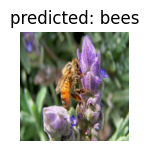

predicted: bees (1)


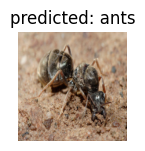

predicted: ants (0)


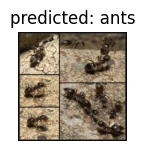

predicted: ants (0)


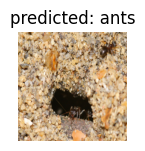

predicted: ants (0)


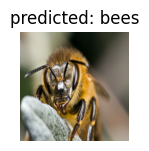

predicted: bees (1)


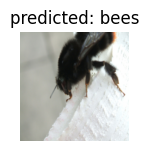

predicted: bees (1)


In [61]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## 5.3) Visualizing training and validation losses

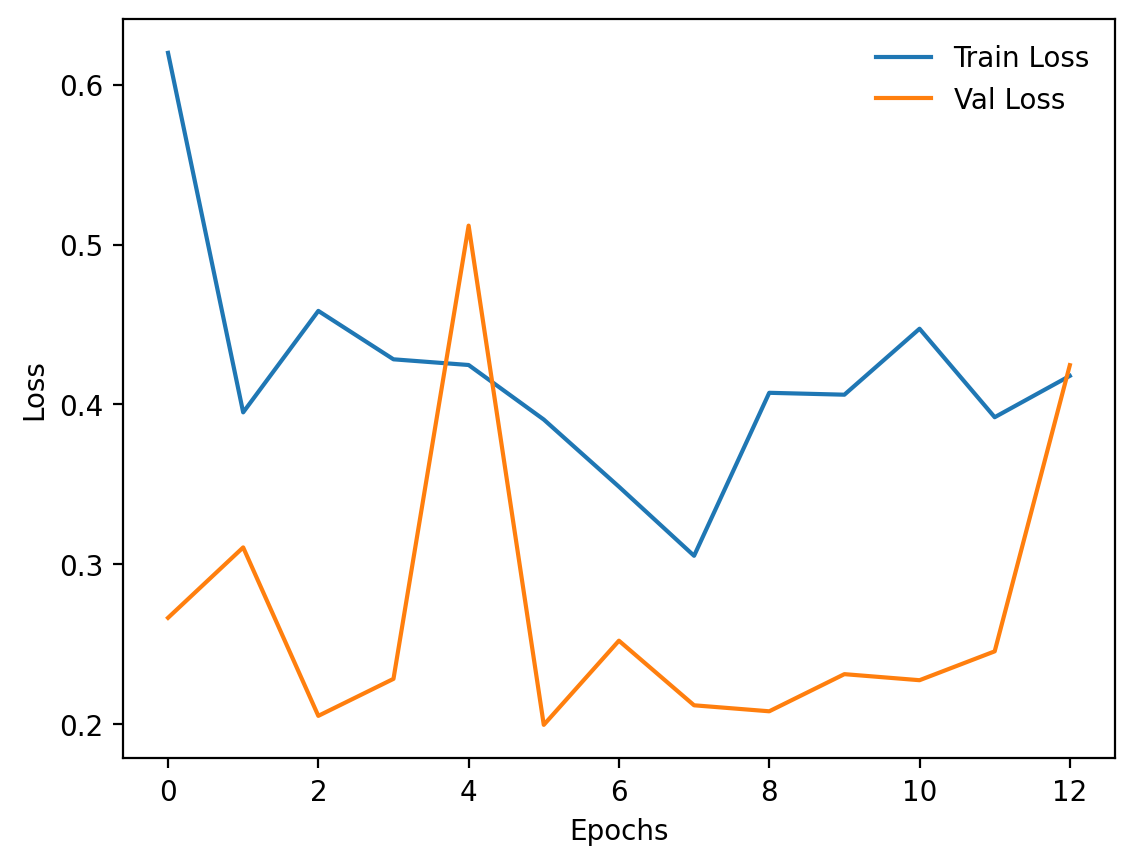

In [63]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

## 5.4) Saving the model

In [64]:
if notebook_run == 0:
  model_filename = root_class_names + '-OLL_FT.pth' # Only Last Layer
else:
  model_filename = root_class_names + '-OLL_FT_custom.pth' # Only Last Layer

torch.save(model_conv.state_dict(), model_filename)

# download checkpoint file
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 6) Training a custom model

Go back to Step 2), arrange your own custom dataset and re-run the notebook with `notebook_run = 1` to train your Raspberry Pi models.

# Step 7) Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).



